In [466]:
from __future__ import print_function
from keras.preprocessing.image import load_img, save_img, img_to_array
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import time
import argparse
import cv2
from tensorflow.keras.models import load_model
import numpy as np
import csv 
import sys
from keras.applications import vgg16
from keras import backend as K
import numpy as np
import cv2
from matplotlib import pyplot as plt
!pwd

/content


In [467]:
img = cv2.imread('/content/800px_COLOURBOX2151826.jpg')
print (img.shape)
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
mask = np.zeros(img.shape[:2],np.uint8)

bgdModel = np.zeros((1,65),np.float64)

fgdModel = np.zeros((1,65),np.float64)
height, width = img.shape[:2]


(800, 473, 3)


In [0]:
rect = (0,0,width-10,height-10)
cv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)

mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
imgnew= img*mask2[:,:,np.newaxis]
background=img-imgnew
background[np.where((background>[0,0,0]).all(axis=2))]=[255,255,255]

final=background+imgnew
#print mask2

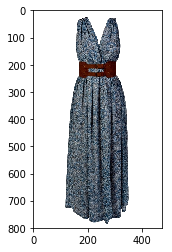

In [469]:
plt.imshow(final)
save_img("fd.png",final)
plt.show()


In [0]:

base_image_path = "/content/fd.png"
style_reference_image_path = "/content/images.jpeg"
#style2="/content/1*JQKUL-npoJOXnTxIqd7poQ.jpeg"
result_prefix = "results"
iterations = 10
total_variation_weight =0.1
style_weight = 4.5
content_weight = 0.005

In [471]:
width, height = load_img(base_image_path).size
print (width)
img_nrows = 400
img_ncols = int(width * img_nrows / height)

473


In [0]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg16.preprocess_input(img)
    return img

In [0]:
def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, img_nrows, img_ncols))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [0]:
base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_reference_image_path))
#style_reference2 = K.variable(preprocess_image(style2))


In [0]:
if K.image_data_format() == 'channels_first':
    combination_image = K.placeholder((1, 3, img_nrows, img_ncols))
else:
    combination_image = K.placeholder((1, img_nrows, img_ncols, 3))

# combine the 3 images into a single Keras tensor
input_tensor = K.concatenate([base_image,
                              style_reference_image,
                              combination_image], axis=0)

In [476]:
model = vgg16.VGG16(input_tensor=input_tensor,
                    weights='imagenet', include_top=False)
print('Model loaded.')

# get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

Model loaded.


In [0]:

def gram_matrix(x):
    assert K.ndim(x) == 3
    if K.image_data_format() == 'channels_first':
        features = K.batch_flatten(x)
    else:
        features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

In [0]:
def style_loss(style,combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S-C)) / (4.0 * (channels ** 2) * (size ** 2))

In [0]:
# def style_loss(style,style_ref2,combination):
#     assert K.ndim(style) == 3
#     assert K.ndim(combination) == 3
#     S = gram_matrix(style)
#     S2= gram_matrix(style_ref2)
#     C = gram_matrix(combination)
#     channels = 3
#     size = img_nrows * img_ncols
#     return K.sum(K.square(S+S2-C)) / (4.0 * (channels ** 2) * (size ** 2))

In [0]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

In [0]:
def total_variation_loss(x):
    assert K.ndim(x) == 4
    if K.image_data_format() == 'channels_first':
        a = K.square(
            x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, 1:, :img_ncols - 1])
        b = K.square(
            x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, :img_nrows - 1, 1:])
    else:
        a = K.square(
            x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
        b = K.square(
            x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [482]:
loss = K.variable(0.0)
layer_features = outputs_dict['block2_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss += content_weight * content_loss(base_image_features,
                                      combination_features)

In [0]:


#feature_layers = ["block1_conv2", "block2_conv2", "block3_conv3", "block4_conv3", "block5_conv3"]

feature_layers = ['block1_conv1', 'block2_conv1',
                 'block3_conv1', 'block4_conv1',
                  'block5_conv1']

#op=outputs_dict['block5_conv1']
#style_ref2 = op[0, :, :, :]

#plt.imshow(op)
#plt.show()

for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    #style_ref2 = layer_features[2, :, :, :]
    
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features,combination_features)
    loss += (style_weight / len(feature_layers)) * sl
    
loss += total_variation_weight * total_variation_loss(combination_image)

In [0]:
# for layer_name in feature_layers:
#     layer_features = outputs_dict[layer_name]
#     style_reference_features = layer_features[1, :, :, :]
#     style_ref2 = layer_features[2, :, :, :]
    
#     combination_features = layer_features[3, :, :, :]
#     sl = style_loss(style_reference_features,style_ref2,combination_features)
#     loss += (style_weight / len(feature_layers)) * sl
    
# loss += total_variation_weight * total_variation_loss(combination_image)

In [0]:
# get the gradients of the generated image wrt the loss
grads = K.gradients(loss, combination_image)

outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

f_outputs = K.function([combination_image], outputs)


In [0]:
def eval_loss_and_grads(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((1, 3, img_nrows, img_ncols))
    else:
        x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

In [0]:
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values
      
evaluator = Evaluator()

In [0]:
x = preprocess_image(base_image_path)

Start of iteration 0
Current loss value: 11396304000.0
Image saved as kaggle_at_iteration_0.png
Iteration 0 completed in 5s
Start of iteration 1
Current loss value: 6289464000.0
Image saved as kaggle_at_iteration_1.png
Iteration 1 completed in 2s
Start of iteration 2
Current loss value: 5035563000.0
Image saved as kaggle_at_iteration_2.png
Iteration 2 completed in 2s
Start of iteration 3
Current loss value: 4513878500.0
Image saved as kaggle_at_iteration_3.png
Iteration 3 completed in 2s
Start of iteration 4
Current loss value: 4209296100.0
Image saved as kaggle_at_iteration_4.png
Iteration 4 completed in 2s
Start of iteration 5
Current loss value: 4016406000.0
Image saved as kaggle_at_iteration_5.png
Iteration 5 completed in 2s
Start of iteration 6
Current loss value: 3907293200.0
Image saved as kaggle_at_iteration_6.png
Iteration 6 completed in 2s
Start of iteration 7
Current loss value: 3813875200.0
Image saved as kaggle_at_iteration_7.png
Iteration 7 completed in 2s
Start of iterat

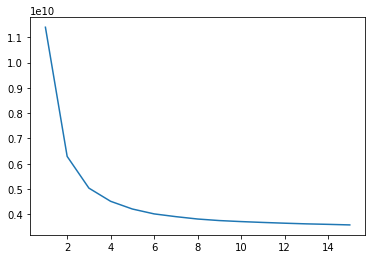

In [489]:
a = []
b = []
for i in range(15):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    a.append(min_val)
    b.append(i+1)
    print('Current loss value:', min_val)
    # save current generated image
    ximg=x.copy()
    img = deprocess_image(x.copy())
    fname = 'kaggle' + '_at_iteration_%d.png' % i
    save_img(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

plt.plot(b,a)

(400, 236, 3)


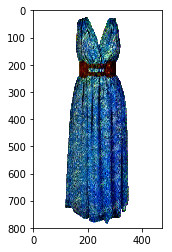

In [490]:
style = cv2.imread('/content/kaggle_at_iteration_15.png')

style=cv2.cvtColor(style,cv2.COLOR_BGR2RGB)
print (style.shape)
styled=cv2.resize(style,(width,height))
styled=styled*mask2[:,:,np.newaxis]
final=background+styled

plt.imshow(final)
save_img("dressSwhatever.png",final)
plt.show()
